In [1]:
from pathlib import Path
import re
import records
from babel.numbers import parse_decimal, NumberFormatError

schema_re = re.compile(r'\((.+)\)')
num_re = re.compile(r'[-+]?\d*\.\d+|\d+')

db_path = Path("./private")
db = records.Database(f"sqlite:///{db_path / 'kospi.db'}")

테이블 명 확인해보기

In [10]:
db.get_table_names()[-5:]

['363280', '365550', '900140', 'company', 'kospi']

각 Column에 해당하는 의미
- rcept_no: 접수번호
- corp_code: 사업 연도
- stock_code: 종목 코드
- reprt_code: 보고서 코드
- account_nm: 계정명 (예: 자본총계)
- fs_div: 개별/연결구분 ('CFS'=연결재무제표, 'OFS'=재무제표)
- fs_nm: 개별/연결명 ('연결재무제표' 또는 '재무제표')
- sj_div: 재무제표구분 ('BS'=재무상태표, 'IS'=손익계산서)
- sj_nm: 재무제표명 ( '재무상태표' 또는 '손익계산서')
- thstrm_nm: 당기명
- thstrm_dt: 당기일자
- thstrm_amount: 당기금액
- thstrm_add_amount: 당기누적금액
- frmtrm_nm: 전기명
- frmtrm_dt: 전기일자
- frmtrm_amount: 전기금액
- frmtrm_add_amount: 전기누적금액
- bfefrmtrm_nm: 전전기명
- bfefrmtrm_dt: 전전일자
- bfefrmtrm_amount: 전전기금액

테이블 스키마 확인

In [7]:
table_id = "095570"
table_info = db.query('SELECT sql from sqlite_master WHERE tbl_name = :name', name=table_id).all()[0].sql
schema_str = schema_re.findall(table_info.replace("\n", ""))[0]
schema = {}
for tup in schema_str.split(', '):
    c, t = tup.split()
    schema[c.strip('"')] = t
schema

{'index': 'INTEGER',
 'rcept_no': 'TEXT',
 'reprt_code': 'TEXT',
 'bsns_year': 'INTEGER',
 'corp_code': 'TEXT',
 'stock_code': 'TEXT',
 'fs_div': 'TEXT',
 'fs_nm': 'TEXT',
 'sj_div': 'TEXT',
 'sj_nm': 'TEXT',
 'account_nm': 'TEXT',
 'thstrm_nm': 'TEXT',
 'thstrm_dt': 'TEXT',
 'thstrm_amount': 'INTEGER'}

# Data Generation

1. Kospi
2. Company
2. recepts: stock codes

## Table: KOSPI

질문 리스트

- 심볼에 해당하는 회사 이름: `SELECT Name FROM kospi WHERE Symbol = '095570'`
- 섹터:
    - 심볼에 해당하는 섹터는 ? `SELECT Sector FROM kospi WHERE Symbol = '095570'`
    - 이름에 해당하는 섹터는 ? `SELECT Sector FROM kospi WHERE Symbol = 'AJ네트웍스'`
- 산업:
    - 심볼에 해당하는 산업은 ? `SELECT Industry FROM kospi WHERE Symbol = '095570'`
    - 이름에 해당하는 산업은 ? `SELECT Industry FROM kospi WHERE Symbol = 'AJ네트웍스'`
    
반대로는?

- 산업: 
    - XX 업을하는 회사는 어디? `SELECT Name FROM kospi WHERE Sector = '산업용 기계 및 장비 임대업'`
    - XX 업을하는 회사 심볼은? `SELECT Symbol FROM kospi WHERE Sector = '산업용 기계 및 장비 임대업'`

In [45]:
from pyjosa.josa import Josa 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from tqdm.notebook import tqdm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False
print([(f.name, f.fname) for f in fm.fontManager.ttflist if 'Nanum' in f.name])
plt.rcParams["font.family"] = 'NanumBarunGothic'

[('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothicLight.ttf'), ('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothicBold.ttf'), ('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothic.ttf'), ('NanumBarunGothic', 'C:\\Users\\simon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\NanumBarunGothicUltraLight.ttf')]


In [12]:
df_kospi = db.query("SELECT * FROM kospi").export("df")
df_kospi.head()

,index,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,0,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21 00:00:00,12월,박대현,http://www.ajnet.co.kr,서울특별시
1,1,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11 00:00:00,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
2,2,027410,KOSPI,BGF,기타 금융업,지주회사,2014-05-19 00:00:00,12월,홍정국,http://www.bgf.co.kr,서울특별시
3,3,282330,KOSPI,BGF리테일,종합 소매업,체인화 편의점,2017-12-08 00:00:00,12월,이건준,http://www.bgfretail.com,서울특별시
4,4,138930,KOSPI,BNK금융지주,기타 금융업,금융지주회사,2011-03-30 00:00:00,12월,김지완,http://www.bnkfg.com,부산광역시


In [52]:
data_path = Path("./newdata")
if not data_path.exists():
    data_path.mkdir()

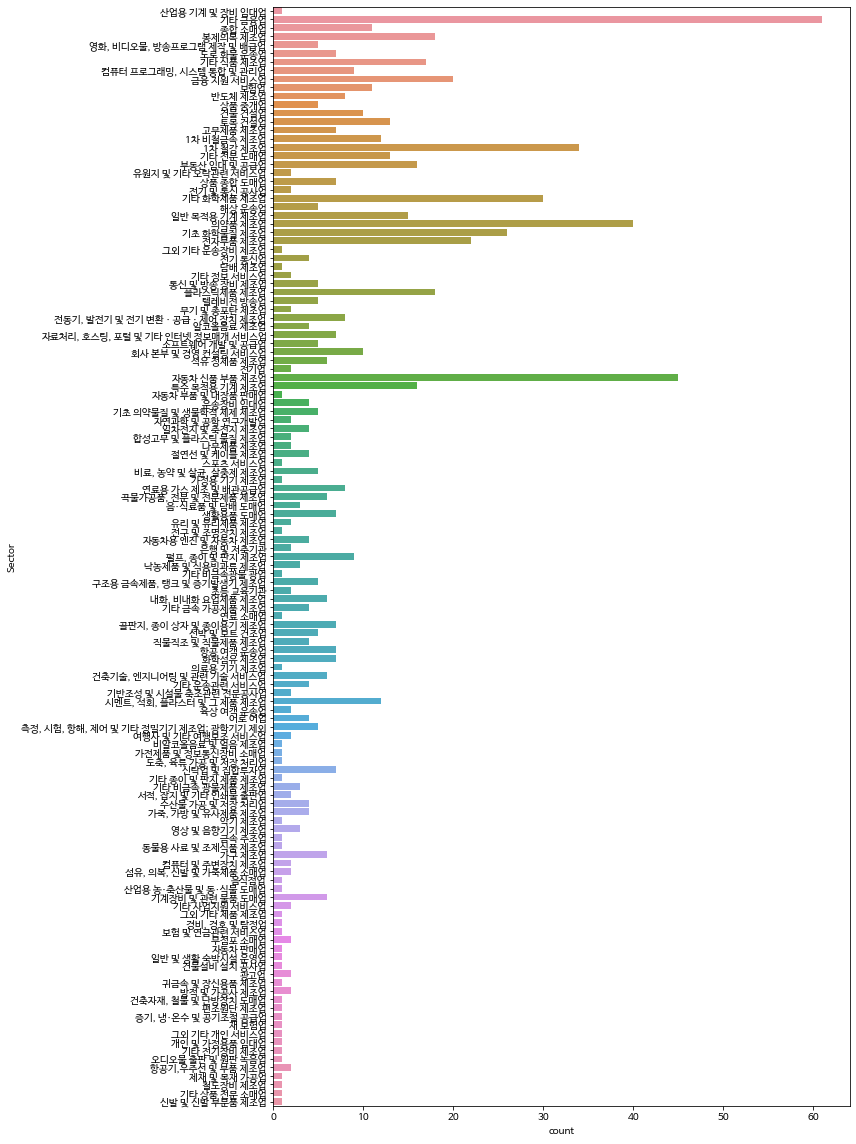

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 16))
sns.countplot(y="Sector", data=df_kospi, ax=ax)
plt.tight_layout()
plt.show()

In [49]:
def create_kospi(df):
    data = []
    symbol_unique = df["Symbol"].unique()
    name_unique = df["Name"].unique()
    cols_1 = ["Name", "Sector", "Industry"]
    logger = tqdm(desc="Creating")
    for col in cols_1:
        if col == "Name":
            for nl_q in ['의 회사 이름이 어떻게 돼?', '의 회사 이름은 뭐야?']:
                for symbol in symbol_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f"SELECT {col} FROM kospi WHERE Symbol = '{symbol}'"
                    data.append(s)
                    logger.update()
        elif col == "Sector":
            for nl_q in [' 회사 무슨 업종이야?', '가 속하는 섹터가 어떻게 돼?', "의 섹터는 뭐야?"]:
                for symbol in symbol_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f"SELECT {col} FROM kospi WHERE Symbol = '{symbol}'"
                    data.append(s)
                    logger.update()
                for name in name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f"SELECT {col} FROM kospi WHERE Name = '{name}'"
                    data.append(s)
                    logger.update()
        elif col == "Industry":
            for nl_q in [' 회사의 산업은?', '가 속하는 산업이 어떻게 돼?']:
                for symbol in symbol_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f"SELECT {col} FROM kospi WHERE Symbol = '{symbol}'"
                    data.append(s)
                    logger.update()
                for name in name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f"SELECT {col} FROM kospi WHERE Name = '{name}'"
                    data.append(s)
                    logger.update()
    
    cols_2 = ["Symbol", "Name"]
    sector_unique = df["Sector"].unique()
    indus_unique = df["Industry"].unique()
    for sec in sector_unique:
        for nl_q in [f"{Josa.get_josa(sec, '을')} 하는 회사는 어디야?", "섹터에 속한 회사들은 뭐가 있어?"]:
            for col in cols_2:
                s = f"{sec}{nl_q}\t"
                s += f"SELECT {col} FROM kospi WHERE Sector = '{sec}'"
                data.append(s)
                logger.update()
    for ind in indus_unique:
        for nl_q in [f"{Josa.get_josa(sec, '을')} 하는 회사는 어디야?", "산업에 속한 회사들은 뭐가 있어?"]:
            for col in cols_2:
                s = f"{ind}{nl_q}\t"
                s += f"SELECT {col} FROM kospi WHERE Sector = '{ind}'"
                data.append(s)
                logger.update()
                
    logger.close()
    return data

In [50]:
kospi_data = create_kospi(df_kospi)

Creating: 0it [00:00, ?it/s]

In [53]:
with (data_path / "kospi.tsv").open("w", encoding="utf-8") as file:
    for line in kospi_data:
        print(line, file=file)

## Table: Company

질문 리스트
- CEO 이름:
    - 심볼에 해당하는 CEO는?  `SELECT ceo_nm FROM kospi WHERE stock_code == '095570'`
    - 이름에 해당하는 CEO는?  `SELECT ceo_nm FROM kospi WHERE stock_name == 'AJ네트웍스'`
    - 영어이름에 해당하는 CEO는?  `SELECT ceo_nm FROM kospi WHERE corp_name_eng == 'AJ Networks Co.,Ltd.'`
- 주소:
    - 심볼에 해당하는 CEO는?  `SELECT adres FROM kospi WHERE stock_code == '095570'`
    - 이름에 해당하는 CEO는?  `SELECT adres FROM kospi WHERE stock_name == 'AJ네트웍스'`
    - 영어이름에 해당하는 CEO는?  `SELECT adres FROM kospi WHERE corp_name_eng == 'AJ Networks Co.,Ltd.'`
- 홈페이지:
    - 심볼에 해당하는 CEO는?  `SELECT hm_url FROM kospi WHERE stock_code == '095570'`
    - 이름에 해당하는 CEO는?  `SELECT hm_url FROM kospi WHERE stock_name == 'AJ네트웍스'`
    - 영어이름에 해당하는 CEO는?  `SELECT hm_url FROM kospi WHERE corp_name_eng == 'AJ Networks Co.,Ltd.'`

In [13]:
df_company = db.query("SELECT * FROM company").export("df")
df_company.head()

,index,corp_name,corp_name_eng,stock_name,stock_code,ceo_nm,corp_cls,jurir_no,bizr_no,adres,hm_url,ir_url,phn_no,fax_no,induty_code,est_dt,acc_mt
0,0,AJ네트웍스 주식회사,"AJ Networks Co.,Ltd.",AJ네트웍스,095570,박대현,Y,1101111874654,2148648586,"서울특별시 송파구 정의로8길 9 (문정동,AJ빌딩)",www.ajnet.co.kr,,02-6363-9999,02-6240-0888,76320,20000210,12
1,1,AK홀딩스(주),"AK Holdings, Inc.",AK홀딩스,006840,"채형석, 이석주(각자 대표이사)",Y,1101110029721,1138110894,서울특별시 마포구 양화로 188 -,www.aekyunggroup.co.kr,,02-768-2923,02-768-2904,64992,19701013,12
2,2,(주)비지에프,"BGF CO., LTD.",BGF,027410,홍정국,Y,1101111105215,1208144752,서울특별시 강남구 테헤란로 405,www.bgf.co.kr,,1577-3663,02-7081398,64992,19941201,12
3,3,(주)비지에프리테일,"BGF retail CO., LTD.",BGF리테일,282330,이건준,Y,1101116555770,8938800792,서울특별시 강남구 테헤란로 405 BGF사옥,www.bgfretail.com,,02-1577-8007,02-528-6820,47122,20171101,12
4,4,(주)BNK금융지주,BNK Financial Group Inc.,BNK금융지주,138930,김지완,Y,1801110750893,6058605385,부산광역시 남구 문현금융로 30(문현동),www.bnkfg.com,,051-620-3023,051-620-3040,64992,20110315,12


In [62]:
def create_company(df):
    data = []
    stock_code_unique = df["stock_code"].unique()
    stock_name_unique = df["stock_name"].unique()
    corp_name_eng_unique = df["corp_name_eng"].unique()
    cols_1 = ["ceo_nm", "adres", "hm_url"]
    logger = tqdm(desc="Creating")
    for col in cols_1:
        if col == "ceo_nm":
            for nl_q in [' 회사의 CEO는 누구야?', ' 회사의 CEO 이름은 뭐야?']:
                for symbol in stock_code_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE stock_code = '{symbol}'"
                    data.append(s)
                    logger.update()
                for name in stock_name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE stock_name = '{name}'"
                    data.append(s)
                    logger.update()
                for eng_name in corp_name_eng_unique:
                    s = f"{eng_name}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE corp_name_eng = '{eng_name}'"
                    data.append(s)
                    logger.update()
        elif col == "adres":
            for nl_q in [' 회사 주소는 뭐야?', ' 회사는 어디에 있어?']:
                for symbol in stock_code_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE stock_code = '{symbol}'"
                    data.append(s)
                    logger.update()
                for name in stock_name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE stock_name = '{name}'"
                    data.append(s)
                    logger.update()
                for eng_name in corp_name_eng_unique:
                    s = f"{eng_name}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE corp_name_eng = '{eng_name}'"
                    data.append(s)
                    logger.update()
        elif col == "hm_url":
            for nl_q in [' 회사의 홈페이지 주소는?', ' 회사의 웹주소가 뭐야?']:
                for symbol in stock_code_unique:
                    s = f"{symbol}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE stock_code = '{symbol}'"
                    data.append(s)
                    logger.update()
                for name in stock_name_unique:
                    s = f"{name}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE stock_name = '{name}'"
                    data.append(s)
                    logger.update()
                for eng_name in corp_name_eng_unique:
                    s = f"{eng_name}{nl_q}\t"
                    s += f"SELECT {col} FROM company WHERE corp_name_eng = '{eng_name}'"
                    data.append(s)
                    logger.update()
    
    logger.close()
    return data

In [63]:
company_data = create_company(df_company)

Creating: 0it [00:00, ?it/s]

In [64]:
with (data_path / "company.tsv").open("w", encoding="utf-8") as file:
    for line in company_data:
        print(line, file=file)

## Table: 재무제표

질문 리스트

- 리포트 번호:
    - 심볼에 해당하는 xx년도의 리포트 번호?  `SELECT rcept_no FROM '095570' WHERE bsns_year = 2018`
    - 심볼에 해당하는 제 xx 기의 리포트 번호?  `SELECT rcept_no FROM'095570' WHERE thstrm_nm = '제 19 기'`
- 계정명:
    - (계정)명은 어디에 속하는지(재무상태표/손익계산서): `SELECT sj_nm FROM '095570' WHERE account_nm = '유동자산'`
    - 심볼에 해당하는 xx년도의 (계정)은?  `SELECT thstrm_amount FROM '095570' WHERE account_nm = '유동자산' AND bsns_year = 2018`
    - 심볼에 해당하는 제 xx 기의 (계정)은?  `SELECT thstrm_amount FROM '095570' WHERE account_nm = '유동자산' AND thstrm_nm = '제 19 기'`
- 기간:
    - 제 xx 기는 언제를 말하는거지? `SELECT thstrm_dt FROM '095570' WHERE thstrm_nm = '제 19 기'`

In [14]:
# receipts 를 판다스 테이블로 불러옴
df_receipts = db.query("SELECT * FROM '095570'").export("df")
# account_nm 계정명
df_receipts["account_nm"].unique()

array(['유동자산', '비유동자산', '자산총계', '유동부채', '비유동부채', '부채총계', '자본금', '이익잉여금',
       '자본총계', '매출액', '영업이익', '법인세차감전 순이익', '당기순이익'], dtype=object)

In [15]:
df_receipts.head()

,index,rcept_no,reprt_code,bsns_year,corp_code,stock_code,fs_div,fs_nm,sj_div,sj_nm,account_nm,thstrm_nm,thstrm_dt,thstrm_amount
0,0,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,유동자산,제 19 기,2018.12.31 현재,-472490384
1,1,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,비유동자산,제 19 기,2018.12.31 현재,-1368425857
2,2,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,자산총계,제 19 기,2018.12.31 현재,-1840916241
3,3,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,유동부채,제 19 기,2018.12.31 현재,-1542563895
4,4,20190531001150,11011,2018,00365387,095570,CFS,연결재무제표,BS,재무상태표,비유동부채,제 19 기,2018.12.31 현재,1814913947


In [77]:
def create_receipts(df, table_id, logger):
    data = []
    account_unique = df["account_nm"].unique()
    bsns_year_unique = df["bsns_year"].unique()
    thstrm_unique = df["thstrm_nm"].unique()
    report_no_unique = df["rcept_no"].unique()
    
    
    for term in thstrm_unique:
        for nl_q in ["는 언제를 말하는 거야?", "는 언제야?"]:
            s = f"{term}{nl_q}\t"
            s += f"SELECT thstrm_dt FROM {table_id} WHERE thstrm_nm = '{term}'"
            data.append(s)
            logger.update()
            
    for rpt_no in report_no_unique:
        for nl_q in ['의 접수번호는 뭐야?', ' 의 접수번호는?', '의 보고서 번호가 어떻게 돼?']:
            for bsns_year in bsns_year_unique:
                s = f"{table_id} {bsns_year}연도{nl_q}\t"
                s += f"SELECT rcept_no FROM {table_id} WHERE bsns_year = {bsns_year}"
                data.append(s)
                logger.update()

            for term in thstrm_unique:
                s = f"{table_id} {term}{nl_q}\t"
                s += f"SELECT rcept_no FROM {table_id} WHERE thstrm_nm = {term}"
                data.append(s)
                logger.update()
        
    for account in account_unique:
        for nl_q in [Josa.get_josa(account, "은") + f" 어느 재무보고서에 속하니?", Josa.get_josa(account, "은") + " 어떤 재무제표야?"]:
            s = f"{account}{nl_q}\t"
            s += f"SELECT sj_nm FROM '095570' WHERE account_nm = '{account}'"
            data.append(s)
            logger.update()
        
        for nl_q in [Josa.get_josa(account, "은") + " 얼마야?", Josa.get_josa(account, "은") + " 어떻게 돼?"]:
            for bsns_year in bsns_year_unique:
            
                s = f"{table_id} {bsns_year}연도의 {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE account_nm = '{account}' AND bsns_year = {bsns_year}"
                data.append(s)
                logger.update()
                
                s = f"{table_id} {bsns_year}연도의 {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE bsns_year = {bsns_year} AND account_nm = '{account}'"
                data.append(s)
                logger.update()
                
                s = f"{bsns_year}년 {table_id}의 {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE account_nm = '{account}' AND bsns_year = {bsns_year}"
                data.append(s)
                logger.update()
                
                s = f"{bsns_year}년 {table_id}의 {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE bsns_year = {bsns_year} AND account_nm = '{account}'"
                data.append(s)
                logger.update()
                
            for term in thstrm_unique:
                s = f"{table_id} {term}의 {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE account_nm = '{account}' AND thstrm_nm = '{term}'"
                data.append(s)
                logger.update()
                
                s = f"{table_id} {term}의 {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE thstrm_nm = '{term}' AND account_nm = '{account}'"
                data.append(s)
                logger.update()
                
                s = f"{term}의 {table_id} {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE account_nm = '{account}' AND thstrm_nm = '{term}'"
                data.append(s)
                logger.update()
                
                s = f"{term}의 {table_id} {nl_q}\t"
                s += f"SELECT thstrm_amount FROM {table_id} WHERE thstrm_nm = '{term}' AND account_nm = '{account}'"
                data.append(s)
                logger.update()
    return data

In [82]:
receipts_tables = db.get_table_names()[:-2]
data_dist = []
logger = tqdm()
for t in receipts_tables:
    logger.set_description(f"Creating {t}")
    df_receipts = db.query(f"SELECT * FROM '{t}'").export("df")
    receipts_data = create_receipts(df_receipts, t, logger)
    data_dist.append(len(receipts_data))
    with (data_path / f"{t}.tsv").open("w", encoding="utf-8") as file:
        for line in receipts_data:
            print(line, file=file)

0it [00:00, ?it/s]

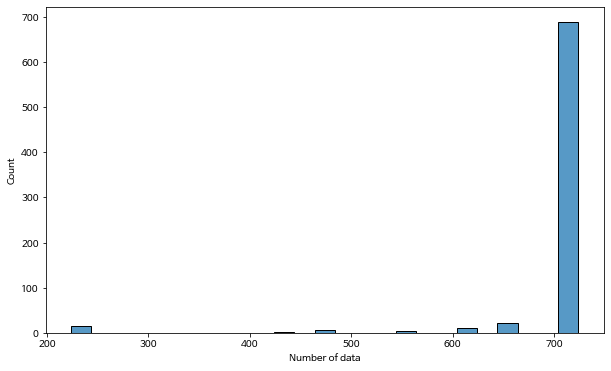

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(data_dist, ax=ax, stat="count", binwidth=20)
ax.set_xlabel("Number of data")
plt.show()

In [88]:
import numpy as np

np.unique(data_dist)

array([224, 242, 436, 470, 560, 610, 660, 710])

In [ ]:
# TODO test train split class

In [93]:
split_ratio = 0.7
len(receipts_tables)

749

In [92]:
idx = np.random.randint(0, )

WindowsPath('newdata')

---

## 데이터 예시

우선 terminology, `[시간]`, `[항목]`의 토큰을 정의하고, 그 다음에 unique한 자연어 질의 먼저 생성하고 SQL을 만들어야 할듯

- 자연어 질의: 제 51 기에 삼성전자의 이익잉여금은 어떻게 돼?
- SQL: 
    ```SQL
    /* Possible answer 1 */
    SELECT frmtrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND bsns_year = 2020
    /* Possible answer 2 */
    SELECT thstrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND bsns_year = 2019
    /* Possible answer 3 */
    SELECT thstrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND thstrm_nm = '제 51 기'
    /* Possible answer 4 */
    SELECT frmtrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND frmtrm_nm = '제 51 기'
    ```

<details>
<summary>Jsonl 형태:</summary>

```json
{
   "phase":1,
   "question":"제 51 기에 삼성전자의 유동자산은 어떻게 돼?",
   "sql":{
      "conds":[
         [10, 0, "이익잉여금"], [3, 0, 2020]
      ],
      "sel":16,
      "agg":0
   },
   "table_id":"receipts"
}
{
   "phase":1,
   "question":"제 51 기에 삼성전자의 유동자산은 어떻게 돼?",
   "sql":{
      "conds":[
         [10, 0, "이익잉여금"], [3, 0, 2019]
      ],
      "sel":13,
      "agg":0
   },
   "table_id":"receipts"
}
...
```
</details>

- `phase`: the phase in which the dataset was collected. We collected WikiSQL in two phases.
- `question`: the natural language question written by the worker.
- `table_id`: the ID of the table to which this question is addressed.
- `sql`: the SQL query corresponding to the question. This has the following subfields:
  - `sel`: the numerical index of the column that is being selected. You can find the actual column from the table.
  - `agg`: the numerical index of the aggregation operator that is being used. You can find the actual operator from `Query.agg_ops` in `lib/query.py`.
  - `conds`: a list of triplets `(column_index, operator_index, condition)` where:
    - `column_index`: the numerical index of the condition column that is being used. You can find the actual column from the table.
    - `operator_index`: the numerical index of the condition operator that is being used. You can find the actual operator from `Query.cond_ops` in `lib/query.py`.
    - `condition`: the comparison value for the condition, in either `string` or `float` type.

In [9]:
from pyjosa.josa import Josa

질문: 

1. 계정항목?
2. 추가 간단한 질문들?

In [12]:
sqls = [
    "SELECT frmtrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND bsns_year = 2020",
    "SELECT thstrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND bsns_year = 2019",
    "SELECT thstrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND thstrm_nm = '제 51 기'",
    "SELECT frmtrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND frmtrm_nm = '제 51 기'"
]
for sql in sqls:
    res = db.query(sql)
    print(res.as_dict()[0])

{'frmtrm_amount': 254582894000000}
{'thstrm_amount': 254582894000000}
{'thstrm_amount': 254582894000000}
{'frmtrm_amount': 254582894000000}


In [1]:
import re
import records
from pathlib import Path
from typing import Union
from moz_sql_parser import parse as sql_parser
schema_re = re.compile(r'\((.+)\)')

class DBEngine:
    
    agg_ops = ["", "MAX", "MIN", "COUNT", "SUM", "AVG"]
    cond_ops = ["=", ">", "<", "OP", ">=", "<="]
    cond_ops_dict = {"eq": "=", "lt": "<",  "lte": "<=", "gt": ">", "gte": ">=", "neq": "<>"}

    syms = ["SELECT", "WHERE", "AND", "COL", "TABLE", "CAPTION", "PAGE", "SECTION", "OP", "COND", "QUESTION", "AGG", "AGGOPS", "CONDOPS"]
    
    def __init__(self, db_path: Union[Path, str]) -> None:
        self.db = records.Database(f"sqlite:///{db_path}")
        self._reset()
        
    def _reset(self) -> None:
        self.table_id = None
        self.schema = None
        self.col2idx = None
        
    def get_schema_info(self, table_id: str) -> None:
        table_info = self.db.query('SELECT sql from sqlite_master WHERE tbl_name = :name', name=table_id).all()[0].sql
        schema_str = schema_re.findall(table_info.replace("\n", ""))[0]
        schema = {}
        for tup in schema_str.split(', '):
            c, t = tup.split()
            schema[c.strip('"')] = t
        col2idx = {c: i for i, c in enumerate(schema.keys())}
        
        self.table_id = table_id
        self.schema = schema
        self.col2idx = col2idx
    
    def to_jsonl_table(self, table_id: str) -> dict:
        if self.table_id is None:
            self._reset()
            self.get_schema_info(table_id)
        table = {"id": self.table_id, "header": list(self.schema), "types": list(self.schema.values()), "rows": []}
        q = f"SELECT * FROM {self.table_id}"
        res = self.db.query(q)
        for row in res.all():
            table["rows"].append(list(row.values()))
        return table
    
    def to_jsonl_sql(self, sql: str, question: str) -> dict:
        r"""
        # Only 1 agg and select
        example:
        - sql: "SELECT frmtrm_amount FROM receipts WHERE account_nm = '이익잉여금' AND bsns_year = 2020",
        - question: "제 51 기에 삼성전자의 유동자산은 어떻게 돼?"
        
        return:
        {
           "phase":1,
           "question":"제 51 기에 삼성전자의 유동자산은 어떻게 돼?",
           "sql":{
              "conds":[
                 [10, 0, "이익잉여금"], [3, 0, 2020]
              ],
              "sel":16,
              "agg":0
           },
           "table_id":"receipts"
        }
        
        """
        
        parsed = sql_parser(sql)
        table_id = parsed["from"]
        jsonl = {"phase": 1, "question": question, "table_id": table_id, "sql": {}}
        
        if (self.table_id is None) or (self.table_id != table_id):
            self.get_schema_info(table_id)
#         else:
#             raise AttributeError("No schema information, please make sure to call `self.get_schema_info`")
        
        select_parsed = parsed["select"]["value"]
        if isinstance(select_parsed, dict):
            # Only 1 agg and select
            agg_name = list(select_parsed)[0]
            agg = self.agg_ops.index(agg_name.upper())
            select_name = select_parsed[agg]
        elif isinstance(select_parsed, str):
            agg = 0
            select_name = select_parsed
        else:
            raise TypeError(f"Parsed in select clause should be `str` or `dict` type, Current is {select_parsed}")
        select = self.col2idx.get(select_name)
        
        conds_parsed = parsed["where"]
        conds = []
        for operator, conditions in conds_parsed.items():
            # cond = {operator.upper(): []}
            # Is operator always AND?
            for condition in conditions:
                key, values = tuple(condition.items())[0]

                if self.cond_ops_dict.get(key) is None:
                    raise KeyError(f"No operator: {key}")
                else:
                    op = self.cond_ops_dict.get(key)
                    op_idx = self.cond_ops.index(op)
                    
                if self.col2idx.get(values[0]) is None:
                    raise KeyError(f"No column name: {values[0]}")
                else:
                    col_idx = self.col2idx.get(values[0])
                    
                
                if isinstance(values[1], dict):
                    # make sure all string values insert '' when parse to sql again
                    cond_value = values[1]["literal"]
                else:
                    cond_value = values[1]
                # cond[operator.upper()].append([col_idx, op_idx, cond_value])
                cond = [col_idx, op_idx, cond_value]
                conds.append(cond)
        
        jsonl["sql"]["sel"] = select
        jsonl["sql"]["agg"] = agg
        jsonl["sql"]["conds"] = conds
        return jsonl
    
    def to_sql(self, sql_jsonl: dict) -> str:
        table_id = sql_jsonl["table_id"]
        if self.table_id != table_id:
            self._reset()
            self.get_schema_info(table_id)
        
        
        sql_dict = sql_jsonl["sql"]  # dict_keys(['sel', 'agg', 'conds'])
        sel_idx = sql_dict["sel"]
        col = list(self.schema)[sel_idx]
        agg_idx = sql_dict["agg"]
        agg = self.agg_ops[agg_idx]
        
        conds = sql_dict["conds"]
        cond_str = ""
        for col_idx, op_idx, cond_value in conds:
            cond_value = f"'{cond_value}'" if isinstance(cond_value, str) else cond_value
            cond_str += f"{list(self.schema)[col_idx]} {self.cond_ops[op_idx]} {cond_value}"
            cond_str += " AND "
        
        query = f"SELECT {agg}({col}) FROM {self.table_id} WHERE {cond_str}"
        return query

In [2]:
db_path = Path("./private")
sql_gen = DBEngine(db_path=db_path / "samsung_new.db")

In [3]:
tsv_file = Path("./NLSQL.tsv")

with tsv_file.open("r", encoding="utf-8") as file:
    data = [line.strip() for line in file.readlines()]
data = [line.split("\t") for line in data]

In [ ]:
import jsonlines

In [37]:
sql_file = Path("./NLSQL.jsonl")

with jsonlines.Writer(sql_file.open("w")) as file:
    for line in data:
        question, sql, answer = line
        file.write(sql_gen.to_jsonl_sql(sql, question))

In [40]:
table_file = Path("./table.jsonl")
table = sql_gen.to_jsonl_table("receipts")

with jsonlines.Writer(table_file.open("w")) as file:
    file.write(table)